In [1]:
import sys
import os
from tqdm import tqdm
# from src.models.setup_model import setup_sam2, load_sam2

# Aggiunge il percorso del progetto al PYTHONPATH
current_dir = os.path.abspath(os.getcwd())
project_home_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

sys.path.append(project_home_dir)

# # Carica il modello SAM2
# setup_sam2(project_home_dir)
# predictor = load_sam2(project_home_dir)

In [ ]:
import src.data.make_dataset as make_dataset
import src.data.image_info as image_info

slice_dict = make_dataset.load_image_slices(os.path.join(project_home_dir, r"data\raw"))
masks_path_list = {
    'BZ2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png",
    'BZ3': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ3_preprocessed_collagen_tissue_mask.png",
    'BZ5': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ5_preprocessed_collagen_tissue_mask.png",
    'BZ6': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ6_preprocessed_collagen_tissue_mask.png",
    'RE1': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE1_preprocessed_collagen_tissue_mask.png",
    'RE2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE2_preprocessed_collagen_tissue_mask.png",
}


for slice_id in tqdm(slice_dict):
    mask_path = masks_path_list[slice_id]
    imageInfo = image_info.ImageSlice(slice_id)
    imageInfo.load_images(slice_dict[slice_id]['wga'], slice_dict[slice_id]['collagen'], slice_dict[slice_id]['autofluorescence'])
    imageInfo.analyse_image2(mask_path)
    imageInfo.save_results()

In [6]:
from src.models.segmentation import extract_features, perform_clustering
import cv2
def superpixel_clustering_segmentation(gray,  segments, n_clusters=2):
    """
    Funzione principale per la segmentazione con superpixel e clustering KMeans.

    Args:
        image_path: Percorso dell'immagine in scala di grigi
        mask_path: Percorso della maschera binaria
        segments: Superpixel in cui è stata suddivisa l'immagine
        n_clusters: Numero di cluster

    Returns:
      
    """
    if len(gray.shape) == 3:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    else:
        gray = gray


    features = extract_features(gray, segments)
    masks = perform_clustering(features, segments, n_clusters)
    
    return masks

In [2]:
import cv2
import numpy as np
from skimage.segmentation import slic
from src.data.pre_process_image import enhance_image
from src.data.pre_process_image import load_tif_image, resize_image
from src.data.pre_process_image import generate_superpixels
import src.models.segmentation as seg
import src.visualization.visualize as vis

mask = cv2.imread(r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png", cv2.IMREAD_GRAYSCALE)
image  = load_tif_image(r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\raw\BZ2_BZ2_CH1_AUTO_MIP.tif")
image = resize_image(image, 0.5)
image = enhance_image(image, mask)

segments = generate_superpixels(image, mask, n_superpixels=600)

# superpixel_viz, segmented_viz = seg.superpixel_rag_segmentation(image, mask, segments=segments)


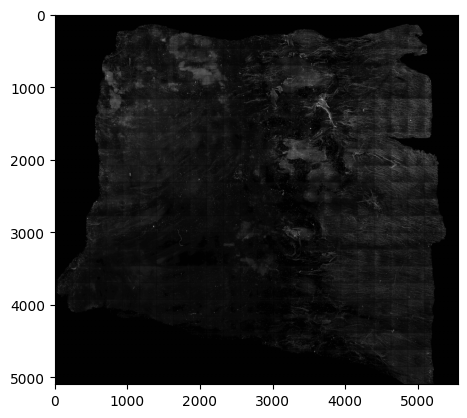

In [4]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray')
plt.show()


In [ ]:
masks = superpixel_clustering_segmentation(image, segments, n_clusters=2)

In [ ]:
def plot_masks(masks):
    """
    Visualizza le maschere generate per ciascun cluster.

    Args:
        masks: Lista di maschere (una per ciascun cluster)
    """
    n_masks = len(masks)
    
    fig, axes = plt.subplots(1, n_masks, figsize=(15, 5))
    
    for i, mask in enumerate(masks):
        ax = axes[i]
        ax.imshow(mask, cmap='gray')  # Visualizza ogni maschera in scala di grigi
        ax.set_title(f"Cluster {i + 1}")
        ax.axis('off')  # Rimuovi gli assi per una visualizzazione più pulita
    
    plt.tight_layout()
    plt.show()

plot_masks(masks)